# <center>LDA for prediction of sex of scallops  <center>

#### ANGEL LAL 

### DATA DESCRIPTION
Predicting the sex of scallops from physical measurements. The sex of scallops is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the gender.

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report 
from pingouin import multivariate_normality

In [15]:
data = pd.read_excel("D:\MSTAT\SEM 3\Machine Learning\ML LAB\scallops.xls")

In [16]:
data.head()

,Y,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [17]:
data.shape

(4177, 8)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Y               4177 non-null   int64  
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 261.2 KB


### Attribiute Information
- Sex / nominal / 0 - Female, 1 - male
- Length / continuous / mm / Longest shell measurement
- Diameter / continuous / mm / perpendicular to length
- Height / continuous / mm / with meat in shell
- Whole weight / continuous / grams / whole abalone
- Shucked weight / continuous / grams / weight of meat
- Visecera weight / continuous / grams / gut weight (after bleeding)
- Shell weight / continuous / grams / after being dried



### EDA

In [21]:
data.describe()

,Y,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.365813,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831
std,0.481715,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000
50%,0.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000
75%,1.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000
max,1.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


In [23]:
data['Y'].value_counts()

0    2649
1    1528
Name: Y, dtype: int64

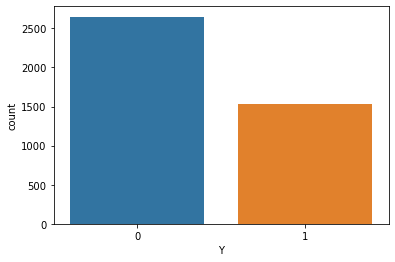

In [25]:
sns.countplot(x='Y',data=data)
plt.show()

In [26]:
count_f = len(data[data['Y']==0])
count_m = len(data[data['Y']==1])
pct_of_f = count_f/(count_f+count_m)
print("percentage of female is", pct_of_f*100)
pct_of_m = count_m/(count_f+count_m)
print("percentage of male is", pct_of_m*100)

percentage of female is 63.41872157050514
percentage of male is 36.58127842949485


From the countplot and percentage of the classes we can observe a shift towards Female class. Hence the problem of imbalanced classification arrives

In [27]:
data.groupby('Y').mean()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
Y,,,,,,,
0,0.502420,0.389766,0.132673,0.734883,0.316926,0.160433,0.213948
1,0.561391,0.439287,0.151381,0.991459,0.432946,0.215545,0.281969


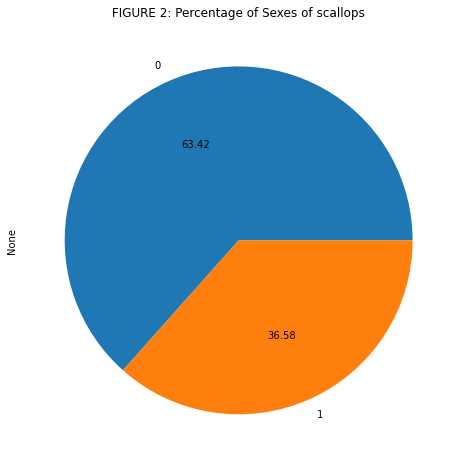

In [33]:
data.groupby('Y').size().plot(kind='pie', autopct='%.2f',figsize=(8,8))
plt.title("FIGURE 2: Percentage of Sexes of scallops")
plt.show()

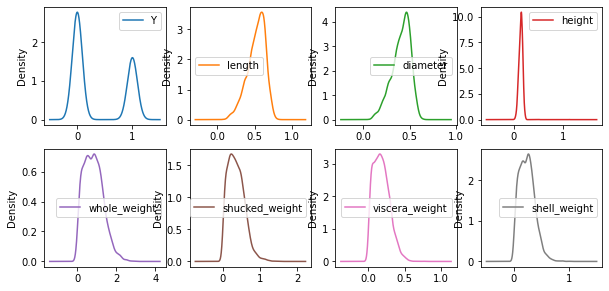

In [37]:
data.plot(kind='density', subplots=True, layout=(4,4), sharex=False, figsize=(10,10))
plt.title('FIGURE 3: Line Graphs')
plt.show()

From this we can see that none of the varaibles have a normal distribution.

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

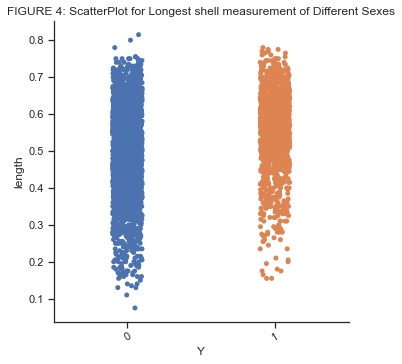

In [39]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x="Y", y="length", data=data)
plt.title('FIGURE 4: ScatterPlot for Longest shell measurement of Different Sexes')
plt.xticks(rotation=30)

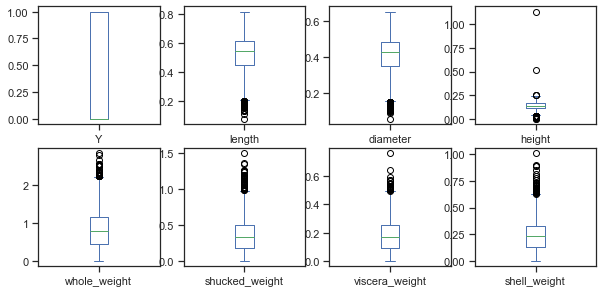

In [41]:
data.plot(kind='box', subplots=True, layout=(4,4), sharex=False,sharey=False, figsize=(10,10))
plt.title('FIGURE 5: BoxPlot ')
plt.show()

All the variables have outliers in them

### Synthentic Minority Oversampling Technique (SMOTE)

In [30]:
X = data.loc[:, data.columns != 'Y']
y = data.loc[:, data.columns == 'Y']

In [31]:
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Y'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of Females in oversampled data",len(os_data_y[os_data_y['Y']==0]))
print("Number of males in oversampled data",len(os_data_y[os_data_y['Y']==1]))
print("Proportion of females in oversampled data is ",len(os_data_y[os_data_y['Y']==0])/len(os_data_X))
print("Proportion of males in oversampled data is ",len(os_data_y[os_data_y['Y']==1])/len(os_data_X))

length of oversampled data is  3680
Number of Females in oversampled data 1840
Number of males in oversampled data 1840
Proportion of females in oversampled data is  0.5
Proportion of males in oversampled data is  0.5


### MODEL 1: LINEAR DISCRIMINANT ANALYSIS

#### Checking for multivariate normality
$H_0$: The distribution of data is not significantly different from multivariate normal<br>
$H_1$: The distribution of data is significantly different from multivariate normal

In [44]:
multivariate_normality(X,alpha=0.05)

HZResults(hz=42.47206682744939, pval=0.0, normal=False)

pval<0.05. Hence we are rejecting H0. The distribution of data is significantly different from multivariate normal

In [45]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=101)

In [46]:
lda=LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)

C:\Users\angel\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis()

In [47]:
y_predict=lda.predict(X_test)
ac=accuracy_score(y_test,y_predict)
print("The accuracy score is ", round(100*ac,4),"%")

The accuracy score is  63.3493 %


In [48]:
confusion_matrix(y_test,y_predict)

array([[589,  62],
       [321,  73]], dtype=int64)

The confusion matrix explains 589+73 = 662 correct predictions and 321+73 = 394 wrong predictions

This model gives more correct predictions than and wrong predictions which is an indication of a good model

In [50]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.65      0.90      0.75       651
           1       0.54      0.19      0.28       394

    accuracy                           0.63      1045
   macro avg       0.59      0.55      0.52      1045
weighted avg       0.61      0.63      0.57      1045



### MODEL 2: QUADRATIC DISCRIMINANT ANALYSIS

In [55]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train,y_train)

C:\Users\angel\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


QuadraticDiscriminantAnalysis()

In [56]:
y_predict=qda.predict(X_test)
ac=accuracy_score(y_test,y_predict)
print("The accuracy score is ", round(100*ac,4),"%")

The accuracy score is  61.9139 %


In [57]:
confusion_matrix(y_test,y_predict)

array([[539, 112],
       [286, 108]], dtype=int64)

The confusion matrix explains 539 + 108 = 647 correct predictions and 112 + 286 = 398 wrong predictions

In [58]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.65      0.83      0.73       651
           1       0.49      0.27      0.35       394

    accuracy                           0.62      1045
   macro avg       0.57      0.55      0.54      1045
weighted avg       0.59      0.62      0.59      1045



# REPORT

Here the problem considered was to predict the sex of scallops using it's physical measurments.

From the count plot the proportion of females to males were found out to be 64 - 36. Hence SMOTE was implemnented. 

- Both linear discriminant analysis and qudratic discriminant analysis were applied on the data. 
- LDA showed 63.349% of accuracy while QDA exhibited 61.914% of accuracy. 
- LDA gave 61% of precision while QDA provided 59% of precsion
- LDA exhibited better score in F1-score also

Hence we can conclude that LDA is better in this model prediction. This can be because of violation of the normality assumption.


